In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import random
from sklearn.decomposition import PCA
from scipy.special import gamma, logsumexp, gammaln

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
print(device)

cuda


Train size: 200, Holdout size: 80, Test size: 120


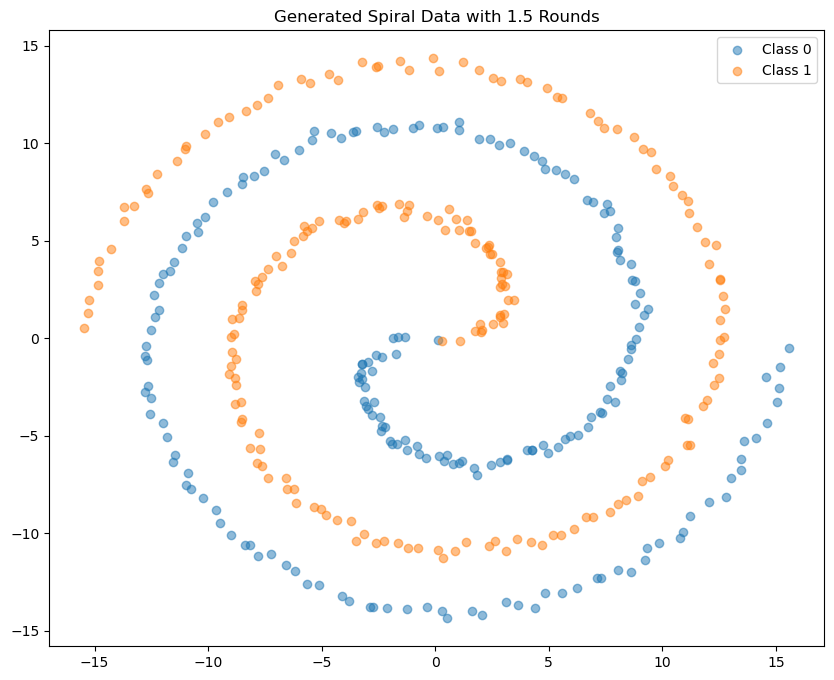

In [5]:
def generate_spiral_data(n_points = 1000, n_cycles = 5, noise_std_dev = 0.1):
    red_noise = np.random.normal(0, noise_std_dev, [2, n_points])
    blue_noise = np.random.normal(0, noise_std_dev, [2, n_points])

    # Generate Data
    theta_max = n_cycles * (2 * math.pi)
    step_size = theta_max / n_points

    red_data = [[5 * math.sqrt(t * step_size) * math.cos(t * step_size) + red_noise[0][t],
                 5 * math.sqrt(t * step_size) * math.sin(t * step_size) + red_noise[1][t]]
                for t in range(n_points)]

    blue_data = [[-5 * math.sqrt(t * step_size) * math.cos(t * step_size) + blue_noise[0][t],
                  -5 * math.sqrt(t * step_size) * math.sin(t * step_size) + blue_noise[1][t]]
                 for t in range(n_points)]

    data = np.array(red_data + blue_data)
    labels = np.array([1] * n_points + [0] * n_points)

    return list(zip(data, labels))

# Generate data
n_points = 200
n_cycles = 1.5
noise = 0.2
spiral_data = generate_spiral_data(n_points = n_points, n_cycles=n_cycles, noise_std_dev=noise)
random.shuffle(spiral_data)

# Split the data
train_ratio = 0.5
holdout_ratio = 0.2
test_ratio = 1- train_ratio - holdout_ratio

train_size = int(2*n_points * train_ratio)
holdout_size = int(2*n_points * holdout_ratio)
test_size = 2*n_points - train_size - holdout_size

print(f"Train size: {train_size}, Holdout size: {holdout_size}, Test size: {test_size}")

train_data = spiral_data[:train_size]
holdout_data = spiral_data[train_size:train_size + holdout_size]
swapped_holdout_data = [(data, 1 - label) for data, label in holdout_data]
test_data = spiral_data[train_size + holdout_size:train_size + holdout_size + test_size]

# Plot the generated spiral data
data, labels = zip(*spiral_data)
data = np.array(data)
labels = np.array(labels)

plt.figure(figsize=(10, 8))
plt.scatter(data[labels == 0][:, 0], data[labels == 0][:, 1], label='Class 0', alpha=0.5)
plt.scatter(data[labels == 1][:, 0], data[labels == 1][:, 1], label='Class 1', alpha=0.5)
plt.title(f'Generated Spiral Data with {n_cycles} Rounds')
plt.legend()
plt.show()

In [6]:
# Separate coordinates and labels for plotting
train_coords, train_labels = zip(*train_data)
holdout_coords, holdout_labels = zip(*swapped_holdout_data)
test_coords, test_labels = zip(*test_data)

In [7]:
train_coords = torch.tensor(train_coords).float().to(device)
train_labels = torch.tensor(train_labels).float().view(-1, 1).to(device)
holdout_coords = torch.tensor(holdout_coords).float().to(device)
holdout_labels = torch.tensor(holdout_labels).float().view(-1, 1).to(device)
test_coords = torch.tensor(test_coords).float().to(device)
test_labels = torch.tensor(test_labels).float().view(-1, 1).to(device)

untraining_data = train_data + swapped_holdout_data
random.shuffle(untraining_data)
untraining_coords, untraining_labels = zip(*untraining_data)
untraining_coords = torch.tensor(untraining_coords).float().to(device)
untraining_labels = torch.tensor(untraining_labels).float().view(-1, 1).to(device)

/tmp/ipykernel_267590/3382564372.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647429097/work/torch/csrc/utils/tensor_new.cpp:278.)
  train_coords = torch.tensor(train_coords).float().to(device)


# Building a classifier

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 25)
        self.fc2 = nn.Linear(25, 25)
        self.fc3 = nn.Linear(25, 25)
        self.fc4 = nn.Linear(25, 25)
        self.fc5 = nn.Linear(25, 25)
        self.fc6 = nn.Linear(25, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x

In [9]:
def plot_decision_boundary(model, data, labels, title):
    model.eval()
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    grid = np.c_[xx.ravel(), yy.ravel()]
    inputs = torch.tensor(grid).float().to(device)
    outputs = model(inputs)
    preds = outputs > 0
    preds = preds.float()
    preds = preds.view(xx.shape)
    plt.figure(figsize=(12, 8))
    plt.contourf(xx, yy, preds.cpu(), alpha=0.8)
    plt.scatter(data[labels == 0][:, 0], data[labels == 0][:, 1], color='red', label='Class 0')
    plt.scatter(data[labels == 1][:, 0], data[labels == 1][:, 1], color='blue', label='Class 1')
    plt.title(title)
    plt.legend()
    plt.show()

# Checking the loss landscape of the model

In [10]:
def generate_random_directions(model):
    dir1_state_dict = {}
    
    for name, param in model.named_parameters():
        weights = param.data
        dir1 = torch.randn_like(param)
        dir1 = dir1 * torch.norm(weights) / torch.norm(dir1)
        dir1_state_dict[name] = dir1
    
    return dir1_state_dict


In [11]:
def compute_loss_surface(model, directions, alphas, betas, X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, criterion):
    dir1_state_dict, dir2_state_dict = directions
    train_loss_surface = np.zeros((len(alphas), len(betas)))
    test_loss_surface = np.zeros((len(alphas), len(betas)))
    original_state_dict = {name: param.clone() for name, param in model.state_dict().items()}

    for i, alpha in enumerate(alphas):
        for j, beta in enumerate(betas):
            new_state_dict = {}
            for name, param in model.named_parameters():
                new_state_dict[name] = original_state_dict[name] + alpha * dir1_state_dict[name] + beta * dir2_state_dict[name]
            model.load_state_dict(new_state_dict)

            model.eval()
            with torch.no_grad():
                train_outputs = model(X_train_tensor).to(device)
                test_outputs = model(X_test_tensor).to(device)
                train_loss = criterion(train_outputs, y_train_tensor).to(device).item()
                test_loss = criterion(test_outputs, y_test_tensor).to(device).item()

            train_loss_surface[i, j] = train_loss
            test_loss_surface[i, j] = test_loss

    model.load_state_dict(original_state_dict)
    return train_loss_surface, test_loss_surface


In [12]:
def convert_params_into_vectors(params):
    vector = []
    for name, param in params.items():
        vector.append(param.view(-1))

    return torch.cat(vector)

In [13]:
def convert_vector_to_params(model, vector):
    params = {}
    start = 0
    for name, param in model.named_parameters():
        end = start + param.numel()
        params[name] = vector[start:end].view(param.size())
        start = end
    return params

In [14]:
def compute_trajectory(param_history, directions, final_params):
    trajectory = []
    dir1, dir2 = directions

    dir1_vector = convert_params_into_vectors(dir1)
    dir2_vector = convert_params_into_vectors(dir2)
    final_vector = convert_params_into_vectors(final_params)
    for params in param_history:
        vector = convert_params_into_vectors(params)
        alpha = torch.dot(vector - final_vector, dir1_vector) / torch.dot(dir1_vector, dir1_vector)
        beta = torch.dot(vector - final_vector, dir2_vector) / torch.dot(dir2_vector, dir2_vector)
        trajectory.append((alpha.item(), beta.item()))
    
    return trajectory

In [15]:
import plotly.graph_objects as go

def plot_loss_surface_3d(alpha_range, beta_range, loss_surface, trajectory, title, plot_trajectory=True):
    fig = go.Figure(data=[go.Surface(z=loss_surface, x=alpha_range, y=beta_range)])
    fig.update_layout(title=title, scene=dict(xaxis_title='Alpha', yaxis_title='Beta', zaxis_title='Loss'))
    alpha_points = trajectory[:, 0]
    beta_points = trajectory[:, 1]
    loss_points = [loss_surface[np.argmin(np.abs(alpha_range - alpha)), np.argmin(np.abs(beta_range - beta))] for alpha, beta in zip(alpha_points, beta_points)]
    if plot_trajectory:
        fig.add_trace(go.Scatter3d(x=alpha_points, y=beta_points, z=loss_points, mode='markers+lines', marker=dict(size=2, color='red')))
    
    fig.show()


# Testing the model
 - 1000 training epochs - 10000 untraining epochs - 200 points - model

In [16]:
import os
import pickle

save_dir = 'params/spiral/'

# Load param_history and poison_points
with open(os.path.join(save_dir, 'param_history.pkl'), 'rb') as f:
    param_history = pickle.load(f)

with open(os.path.join(save_dir, 'poison_points.pkl'), 'rb') as f:
    poison_points = pickle.load(f)

param_history = [{name: params.cpu() for name, params in state_dict.items()} for state_dict in param_history]
poison_points = [{name: params.cpu() for name, params in state_dict.items()} for state_dict in poison_points]

In [17]:
import numpy as np
from sklearn.manifold import TSNE

param_history_vectors = [convert_params_into_vectors(param) for param in param_history]
poison_points_vectors = [convert_params_into_vectors(param) for param in poison_points]

combined_vectors = np.array(param_history_vectors + poison_points_vectors)

# Apply t-SNE
tsne = TSNE(n_components=2)
combined_tsne = tsne.fit_transform(combined_vectors)

# Split the transformed data back into param_history and poison_points
param_history_tsne = combined_tsne[:len(param_history_vectors)]
poison_points_tsne = combined_tsne[len(param_history_vectors):]

print(param_history_tsne.shape)
print(poison_points_tsne.shape)

(102, 2)
(102, 2)


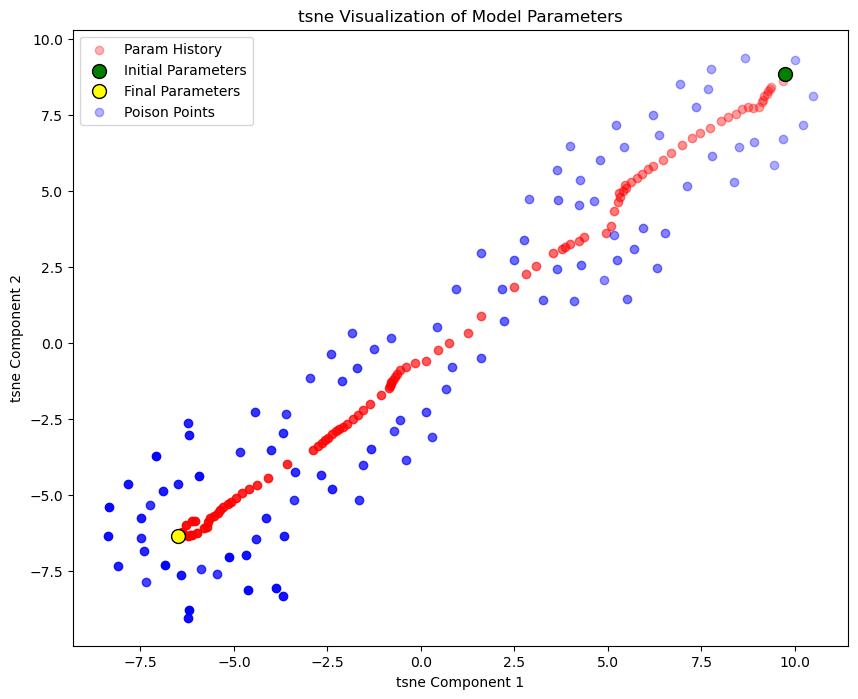

In [18]:
# Normalize the brightness
param_history_colors = np.linspace(0.3, 1, len(param_history_tsne))
poison_points_colors = np.linspace(0.3, 1, len(poison_points_tsne))

# Plot the points
plt.figure(figsize=(10, 8))

# Plot param_history points
for i, (x, y) in enumerate(param_history_tsne):
    plt.scatter(x, y, color=(1, 0, 0, param_history_colors[i]), label='Param History' if i == 0 else "")

plt.scatter(param_history_tsne[0, 0], param_history_tsne[0, 1], color='green', edgecolor='black', s=100, label='Initial Parameters')
plt.scatter(param_history_tsne[-1, 0], param_history_tsne[-1, 1], color='yellow', edgecolor='black', s=100, label='Final Parameters')

# Plot poison_points
for i, (x, y) in enumerate(poison_points_tsne):
    plt.scatter(x, y, color=(0, 0, 1, poison_points_colors[i]), label='Poison Points' if i == 0 else "")

# Add legend
plt.legend()
plt.title('tsne Visualization of Model Parameters')
plt.xlabel('tsne Component 1')
plt.ylabel('tsne Component 2')
plt.show()

# Parallel Code to compute the basin radii

In [24]:
import torch
import numpy as np
from torch.func import functional_call

def flatten_params(state_dict):
    return torch.cat([param.flatten() for param in state_dict.values()])

def unflatten_params(model, flat_tensor):
    """
    Converts a flat tensor back into a parameter mapping compatible with functional_call
    """
    param_dict = {}
    pointer = 0
    for name, param in model.named_parameters():
        numel = param.numel()
        shape = param.shape
        param_dict[name] = flat_tensor[pointer:pointer+numel].view(shape)
        pointer += numel
    return param_dict

def calculate_basin_radii(model, minima_state_dict, loss_fn, train_coords, train_labels,
                          directions=3000, steps=100, max_radius=1.0, cutoff_loss=0.1, device="cuda"):
    """
    Calculates the basin radii in multiple random directions using binary search.
    """
    model.to(device)
    train_coords = train_coords.to(device)
    train_labels = train_labels.to(device)

    flat_minima = flatten_params(minima_state_dict).to(device)
    n_params = flat_minima.numel()

    radii = []

    for i in range(directions):
        direction = torch.randn_like(flat_minima)
        direction /= torch.norm(direction)

        low, high = 0.0, max_radius
        final_loss = None
        tolerance = 1e-4  # You can tweak this

        for _ in range(steps):
            mid = (low + high) / 2
            perturbed = flat_minima + mid * direction
            perturbed_params = unflatten_params(model, perturbed)

            with torch.no_grad():
                outputs = functional_call(model, perturbed_params, (train_coords,))
                loss = loss_fn(outputs, train_labels).item()
                final_loss = loss

            if loss < cutoff_loss:
                low = mid
            else:
                high = mid

            if high - low < tolerance:
                break

        radius = (low + high) / 2
        radii.append(radius)


        print(f"[{i+1}/{directions}] Radius: {radius:.6f}, Loss: {final_loss:.6f}")

    return torch.tensor(radii)


In [26]:

def calculate_log_volume_minima(model, minima_state_dict, loss_fn, train_coords, train_labels,
                                directions=3000, steps=100, max_radius=1.0, cutoff_loss=0.1, device="cuda"):
    """
    Calculates the log-volume of the low-loss basin for a minima.
    
    Args:
        model: The neural network model.
        minima_state_dict: A state_dict corresponding to the minima.
        loss_fn: Loss function used to determine cutoff.
        train_coords: Input data (tensor).
        train_labels: Target labels (tensor).
        directions: Number of random directions to sample.
        steps: Maximum binary search iterations per direction.
        max_radius: Maximum radius to search.
        cutoff_loss: Loss threshold defining the basin boundary.
        device: "cuda" or "cpu".
    
    Returns:
        log_volume (float): The logarithm of the estimated basin volume.
    """
    # First, calculate the radii for the minima.
    radii = calculate_basin_radii(model, minima_state_dict, loss_fn, train_coords, train_labels,
                                      directions=directions, steps=steps, max_radius=max_radius,
                                      cutoff_loss=cutoff_loss, device=device)
    
    # Determine the number of parameters.
    flat_minima = flatten_params(minima_state_dict).to(device)
    n = flat_minima.numel()  # Dimensionality of parameter space.
    
    # Compute log(r^n) for each direction: n * log(radius)
    log_rn = n * torch.log(radii + 1e-12)
    
    # Compute the log-mean using logsumexp for stability.
    log_mean_rn = torch.logsumexp(log_rn, dim=0) - np.log(directions)
    
    # Compute the log-volume of the unit n-ball: log(omega_n)
    log_omega_n = (n / 2) * np.log(np.pi) - gammaln(1 + n / 2)
    
    # Total log-volume is the sum of log_omega_n and log_mean_rn
    log_volume = log_omega_n + log_mean_rn
    
    print(f"Estimated log-volume: {log_volume:.6f}")
    return log_volume


In [25]:
def calculate_log_volume_ratio(model, min1_state, min2_state, loss_fn, train_coords, train_labels,
                               directions=1000, steps=50, max_radius=1.0, cutoff_loss=0.1, device="cuda"):
    """
    Calculates the log volume ratio between two minima (min1 / min2).
    
    Returns:
        log_volume_ratio: float (log(V1 / V2))
        mean_radius_1, mean_radius_2: float (for reference)
    """
    # Get dimension of parameter space
    flat_min1 = flatten_params(min1_state).to(device)
    n = flat_min1.numel()

    # Compute radii for both minima
    r1 = calculate_basin_radii(model, min1_state, loss_fn, train_coords, train_labels,
                                   directions, steps, max_radius, cutoff_loss, device)
    r2 = calculate_basin_radii(model, min2_state, loss_fn, train_coords, train_labels,
                                   directions, steps, max_radius, cutoff_loss, device)

    # Compute log E[r^n] to avoid numerical issues
    log_rn_1 = n * torch.log(r1 + 1e-12)
    log_rn_2 = n * torch.log(r2 + 1e-12)

    log_volume_1 = torch.logsumexp(log_rn_1, dim=0) - np.log(directions)
    log_volume_2 = torch.logsumexp(log_rn_2, dim=0) - np.log(directions)

    log_ratio = (log_volume_1 - log_volume_2).item()

    print(f"Mean Radius min1: {r1.mean():.6f}, min2: {r2.mean():.6f}")
    print(f"Estimated log-volume ratio (min1 / min2): {log_ratio:.3f}")
    print(f"Volume ratio: ~10^{log_ratio:.2f}")

    return log_ratio, r1.mean().item(), r2.mean().item()


In [ ]:
%%time
model = Net().to(device)
loss_fn = nn.BCEWithLogitsLoss()
min_1 = param_history[-1]
model = Net().to(device)
radii_good = calculate_basin_radii(model, min_1, loss_fn, train_coords, train_labels, directions=1000, steps=50, max_radius=3.0, cutoff_loss=1)

[1/1000] Radius: 2.429672, Loss: 1.000014
[2/1000] Radius: 2.999954, Loss: 0.948257
[3/1000] Radius: 1.293137, Loss: 1.000141
[4/1000] Radius: 2.999954, Loss: 0.085572
[5/1000] Radius: 1.569717, Loss: 0.999981
[6/1000] Radius: 2.999954, Loss: 0.662004
[7/1000] Radius: 1.850510, Loss: 1.000070
[8/1000] Radius: 1.945999, Loss: 0.999919
[9/1000] Radius: 1.768661, Loss: 1.000203
[10/1000] Radius: 2.280258, Loss: 1.000023
[11/1000] Radius: 2.999954, Loss: 0.939461
[12/1000] Radius: 2.644821, Loss: 1.000117
[13/1000] Radius: 1.901962, Loss: 1.000074
[14/1000] Radius: 2.999954, Loss: 0.913578
[15/1000] Radius: 2.999954, Loss: 0.801178
[16/1000] Radius: 2.602341, Loss: 1.000019
[17/1000] Radius: 1.411057, Loss: 1.000081
[18/1000] Radius: 2.584030, Loss: 1.000019
[19/1000] Radius: 2.165634, Loss: 1.000064
[20/1000] Radius: 2.999954, Loss: 0.856535
[21/1000] Radius: 2.999954, Loss: 0.632805
[22/1000] Radius: 2.999954, Loss: 0.835694
[23/1000] Radius: 2.692886, Loss: 0.999976
[24/1000] Radius: 2.

In [19]:
radii_history = []
indices = np.linspace(0, len(param_history)-1, 10).astype(int)
print(indices)

[  0  11  22  33  44  56  67  78  89 101]


In [ ]:
for index in indices:
    model = Net().to(device)
    min_1 = param_history[index]
    radii = calculate_basin_radii(model, min_1, loss_fn, train_coords, train_labels, directions=1000, steps=50, max_radius=3.0, cutoff_loss=0.5)
    radii_history.append(radii.cpu())

[1/1000] Radius: 0.000046, Loss: 0.697768
[2/1000] Radius: 0.000046, Loss: 0.697768
[3/1000] Radius: 0.000046, Loss: 0.697768
[4/1000] Radius: 0.000046, Loss: 0.697767
[5/1000] Radius: 0.000046, Loss: 0.697768
[6/1000] Radius: 0.000046, Loss: 0.697768
[7/1000] Radius: 0.000046, Loss: 0.697768
[8/1000] Radius: 0.000046, Loss: 0.697768
[9/1000] Radius: 0.000046, Loss: 0.697768
[10/1000] Radius: 0.000046, Loss: 0.697767
[11/1000] Radius: 0.000046, Loss: 0.697767
[12/1000] Radius: 0.000046, Loss: 0.697768
[13/1000] Radius: 0.000046, Loss: 0.697768
[14/1000] Radius: 0.000046, Loss: 0.697767
[15/1000] Radius: 0.000046, Loss: 0.697767
[16/1000] Radius: 0.000046, Loss: 0.697767
[17/1000] Radius: 0.000046, Loss: 0.697767
[18/1000] Radius: 0.000046, Loss: 0.697768
[19/1000] Radius: 0.000046, Loss: 0.697768
[20/1000] Radius: 0.000046, Loss: 0.697768
[21/1000] Radius: 0.000046, Loss: 0.697768
[22/1000] Radius: 0.000046, Loss: 0.697767
[23/1000] Radius: 0.000046, Loss: 0.697767
[24/1000] Radius: 0.

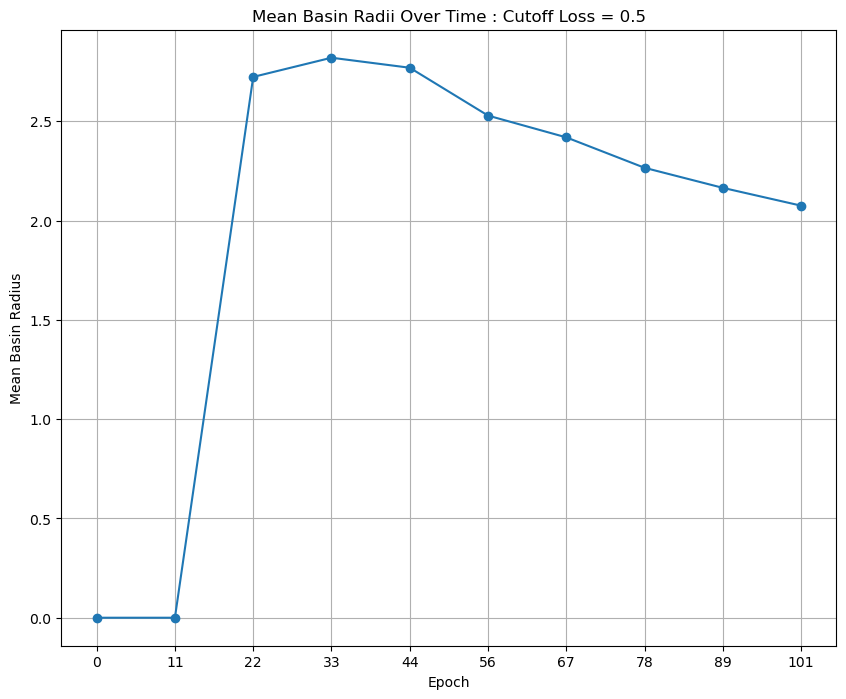

In [23]:
radii_mean = [torch.mean(radii).item() for radii in radii_history]
plt.figure(figsize=(10, 8))
plt.plot(radii_mean, marker='o')
plt.title('Mean Basin Radii Over Time : Cutoff Loss = 0.5')
plt.xlabel('Epoch')
plt.ylabel('Mean Basin Radius')
plt.xticks(range(len(indices)), indices)
plt.grid()
plt.show()

In [24]:
radii_mean

[4.57763671875e-05,
 4.57763671875e-05,
 2.723129987716675,
 2.819807529449463,
 2.769345283508301,
 2.5284175872802734,
 2.418701648712158,
 2.265472412109375,
 2.1645214557647705,
 2.074796676635742]

In [ ]:
radii_history = []
for index in indices:
    model = Net().to(device)
    min_1 = param_history[index]
    radii = calculate_basin_radii(model, min_1, loss_fn, train_coords, train_labels, directions=1000, steps=50, max_radius=3.0, cutoff_loss=0.1)
    radii_history.append(radii.cpu())

[1/1000] Radius: 0.000046, Loss: 0.697767
[2/1000] Radius: 0.000046, Loss: 0.697768
[3/1000] Radius: 0.000046, Loss: 0.697767
[4/1000] Radius: 0.000046, Loss: 0.697767
[5/1000] Radius: 0.000046, Loss: 0.697767
[6/1000] Radius: 0.000046, Loss: 0.697768
[7/1000] Radius: 0.000046, Loss: 0.697767
[8/1000] Radius: 0.000046, Loss: 0.697767
[9/1000] Radius: 0.000046, Loss: 0.697768
[10/1000] Radius: 0.000046, Loss: 0.697768
[11/1000] Radius: 0.000046, Loss: 0.697768
[12/1000] Radius: 0.000046, Loss: 0.697768
[13/1000] Radius: 0.000046, Loss: 0.697768
[14/1000] Radius: 0.000046, Loss: 0.697768
[15/1000] Radius: 0.000046, Loss: 0.697767
[16/1000] Radius: 0.000046, Loss: 0.697767
[17/1000] Radius: 0.000046, Loss: 0.697768
[18/1000] Radius: 0.000046, Loss: 0.697768
[19/1000] Radius: 0.000046, Loss: 0.697768
[20/1000] Radius: 0.000046, Loss: 0.697768
[21/1000] Radius: 0.000046, Loss: 0.697768
[22/1000] Radius: 0.000046, Loss: 0.697767
[23/1000] Radius: 0.000046, Loss: 0.697768
[24/1000] Radius: 0.

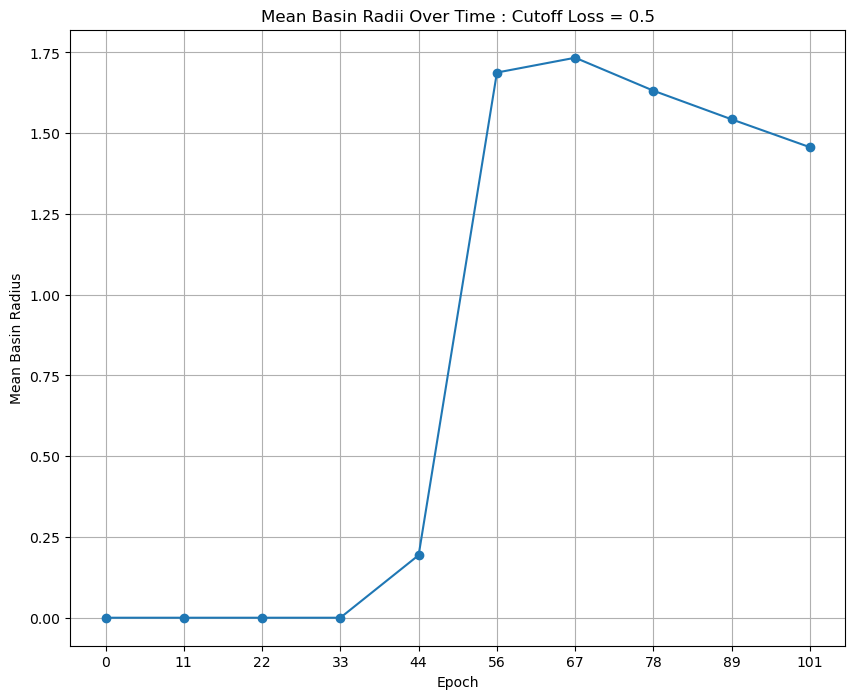

In [26]:
radii_mean = [torch.mean(radii).item() for radii in radii_history]
plt.figure(figsize=(10, 8))
plt.plot(radii_mean, marker='o')
plt.title('Mean Basin Radii Over Time : Cutoff Loss = 0.5')
plt.xlabel('Epoch')
plt.ylabel('Mean Basin Radius')
plt.xticks(range(len(indices)), indices)
plt.grid()
plt.show()

In [27]:
radii_mean

[4.57763671875e-05,
 4.57763671875e-05,
 4.57763671875e-05,
 4.57763671875e-05,
 0.19364702701568604,
 1.687886118888855,
 1.7337864637374878,
 1.6316171884536743,
 1.542924404144287,
 1.4565783739089966]

In [ ]:
cutoff_loss = [0.1, 0.5, 1.0, 3.0, 5.0]
radii_history = []
for cutoff in cutoff_loss:
    radii = []
    for index in indices:
        model = Net().to(device)
        min_1 = param_history[index]
        radii_ = calculate_basin_radii(model, min_1, loss_fn, train_coords, train_labels, directions=1000, steps=50, max_radius=5.0, cutoff_loss=cutoff)
        radii.append(radii_.cpu())
    radii_mean = [torch.mean(radii).item() for radii in radii]
    radii_history.append(radii_mean)

[1/1000] Radius: 0.000038, Loss: 0.697768
[2/1000] Radius: 0.000038, Loss: 0.697767
[3/1000] Radius: 0.000038, Loss: 0.697767
[4/1000] Radius: 0.000038, Loss: 0.697767
[5/1000] Radius: 0.000038, Loss: 0.697768
[6/1000] Radius: 0.000038, Loss: 0.697767
[7/1000] Radius: 0.000038, Loss: 0.697767
[8/1000] Radius: 0.000038, Loss: 0.697767
[9/1000] Radius: 0.000038, Loss: 0.697768
[10/1000] Radius: 0.000038, Loss: 0.697767
[11/1000] Radius: 0.000038, Loss: 0.697768
[12/1000] Radius: 0.000038, Loss: 0.697768
[13/1000] Radius: 0.000038, Loss: 0.697768
[14/1000] Radius: 0.000038, Loss: 0.697768
[15/1000] Radius: 0.000038, Loss: 0.697767
[16/1000] Radius: 0.000038, Loss: 0.697767
[17/1000] Radius: 0.000038, Loss: 0.697767
[18/1000] Radius: 0.000038, Loss: 0.697767
[19/1000] Radius: 0.000038, Loss: 0.697768
[20/1000] Radius: 0.000038, Loss: 0.697768
[21/1000] Radius: 0.000038, Loss: 0.697767
[22/1000] Radius: 0.000038, Loss: 0.697768
[23/1000] Radius: 0.000038, Loss: 0.697768
[24/1000] Radius: 0.

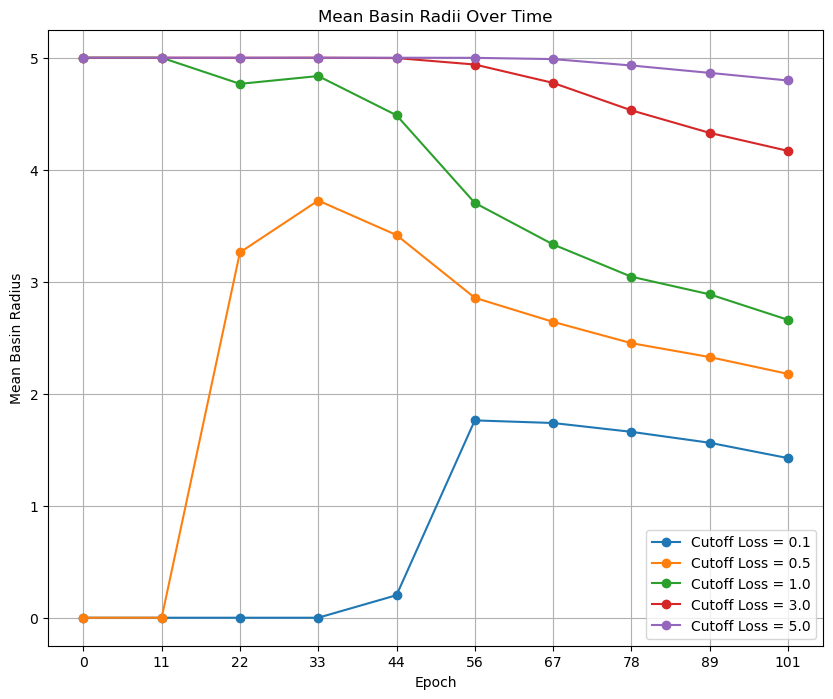

In [29]:
plt.figure(figsize=(10, 8))
for i, cutoff in enumerate(cutoff_loss):
    plt.plot(radii_history[i], marker='o', label=f'Cutoff Loss = {cutoff}')
plt.title('Mean Basin Radii Over Time')
plt.xlabel('Epoch')
plt.ylabel('Mean Basin Radius')
plt.xticks(range(len(indices)), indices)
plt.legend()
plt.grid()
plt.show()

# Volume Calculation
- As the coefficients in the volume expression are very large, we will compute log(ratio)

In [ ]:
model = Net().to(device)
loss_fn = nn.BCEWithLogitsLoss()
min_1 = param_history[-1]
min_2 = poison_points[-1]
log_volume_ratio, mean_radius_1, mean_radius_2 = calculate_log_volume_ratio(model, min_1, min_2, loss_fn, train_coords, train_labels,
                                                                                   directions=1000, steps=50, max_radius=5.0, cutoff_loss=4)

[1/1000] Radius: 4.059639, Loss: 4.000061
[2/1000] Radius: 3.460732, Loss: 4.000005
[3/1000] Radius: 4.999962, Loss: 3.044520
[4/1000] Radius: 4.407539, Loss: 4.000005
[5/1000] Radius: 4.226189, Loss: 3.999957
[6/1000] Radius: 4.999962, Loss: 3.362480
[7/1000] Radius: 4.908333, Loss: 4.000046
[8/1000] Radius: 4.999962, Loss: 2.743138
[9/1000] Radius: 4.999962, Loss: 3.946923
[10/1000] Radius: 4.999962, Loss: 1.282832
[11/1000] Radius: 3.449974, Loss: 3.999846
[12/1000] Radius: 4.999962, Loss: 1.491723
[13/1000] Radius: 4.999962, Loss: 1.743005
[14/1000] Radius: 3.796959, Loss: 3.999920
[15/1000] Radius: 4.999962, Loss: 3.548132
[16/1000] Radius: 4.999962, Loss: 3.433814
[17/1000] Radius: 4.994240, Loss: 4.000037
[18/1000] Radius: 4.485970, Loss: 4.000159
[19/1000] Radius: 4.999962, Loss: 2.348968
[20/1000] Radius: 4.674568, Loss: 4.000046
[21/1000] Radius: 4.471931, Loss: 4.000073
[22/1000] Radius: 3.710136, Loss: 3.999959
[23/1000] Radius: 3.701668, Loss: 4.000189
[24/1000] Radius: 4.

In [27]:
log_volume_1 = calculate_log_volume_minima(model, min_1, loss_fn, train_coords, train_labels,
                                    directions=1000, steps=50, max_radius=5.0, cutoff_loss=4)
log_volume_2 = calculate_log_volume_minima(model, min_2, loss_fn, train_coords, train_labels,
                                    directions=1000, steps=50, max_radius=5.0, cutoff_loss=4)
print(f"Log Volume min1: {log_volume_1:.6f}")
print(f"Log Volume min2: {log_volume_2:.6f}")

[1/1000] Radius: 4.999962, Loss: 2.098893
[2/1000] Radius: 4.999962, Loss: 3.304160
[3/1000] Radius: 4.999962, Loss: 2.280266
[4/1000] Radius: 4.366722, Loss: 3.999966
[5/1000] Radius: 4.999962, Loss: 1.583868
[6/1000] Radius: 4.999962, Loss: 3.647197
[7/1000] Radius: 4.228783, Loss: 3.999928
[8/1000] Radius: 4.999962, Loss: 3.021141
[9/1000] Radius: 4.999962, Loss: 2.555590
[10/1000] Radius: 4.999962, Loss: 2.441583
[11/1000] Radius: 4.999962, Loss: 1.610280
[12/1000] Radius: 4.999962, Loss: 2.522970
[13/1000] Radius: 4.999962, Loss: 3.737397
[14/1000] Radius: 3.989677, Loss: 3.999975
[15/1000] Radius: 3.962288, Loss: 4.000054
[16/1000] Radius: 4.999962, Loss: 3.986994
[17/1000] Radius: 3.247032, Loss: 3.999899
[18/1000] Radius: 3.464317, Loss: 3.999939
[19/1000] Radius: 4.999962, Loss: 1.837327
[20/1000] Radius: 4.999962, Loss: 1.018080
[21/1000] Radius: 3.577309, Loss: 4.000114
[22/1000] Radius: 4.438591, Loss: 3.999995
[23/1000] Radius: 4.999962, Loss: 1.467961
[24/1000] Radius: 4.